This script simulates a stochastic SIR model, constructs the shared ancestry matrix from the simulation. Auxiliary functions are included to convert the shared ancestry matrix to Newick format. Likelihood is calculated given the procedure explained in the paper (MacPherson et al. 2021, DOI:DOI:10.1093/sysbio/syab049). Finally Likelihood surface is explored with varying beta and gamma parameters.  

The first function is dist_calc() which is called in the Gillespie algoirthm. This function updates the shared ancestry matrix whenever is called. Printing lines at the end of the function should be commented out when running Gillespie. 

In [62]:
# a function that updates the shared ancestry matrix
# varaibles are defined global, the function doesn't have a return value
# e is argument of the function and it shows the event order in Gillespie:
# 1 is infection of susceptible, 2 recovery, 3 sampling
# dist is the shared ancestry matrix
# child is a list that keeps the lablel of individuals in the population
# diagonal is a variable that keeps the last diagonal element of the matrix, we add this variable to the end of the matrix when branching event happens
# sampled is a list that keeps the lablel of sampled individuals in the population; so we don't branch or sampled from those 
# tau is the time drawn in the Gillespie algorithm
import numpy as np
import random
def dist_calc(e):   
    global dist, child, diagonal, sampled, tau
    # branch is a varible that is chosen from susceptible individuals. Before getting into the process branch doesn't have any value
    branch = None
    # first event: infection of susceptible 
    if e == 1:
        if child[-1] == 0:
            dist.append(tau)
        elif child[-1] == 1:
            diagonal = dist[0]+tau
            dist = [[dist[0]+tau,dist[0]],[dist[0],dist[0]+tau]]
        elif child[-1] > 1:
            # choosing one of the branches randomly (parent)
            # last child in the list is a progeny and should not be a parent branch so child -1 
            branch = random.choice(list(set(child[:-1])-set().union(recovered, sampled)))
            # adding column of branch to the end of the matrix         
            for j in range(child[-1]):
                dist[j].append(dist[j][branch])
            # adding row of the branch to the end matrix 
            # last row is all elements of the branch row except its last element
            last_row =  dist[branch][slice(0,child[-1])]
            diagonal += tau
            # here I add diagonal element to the last row
            last_row.append(diagonal)
            # adding last row to the matrix
            dist.append(last_row) 
            # add delta t to diagonal of dist for those who have not been sampled
            # the purpose of -1 is to exclude the last element because it already has the +tau
            for i in range(child[-1]):
                if i not in sampled and i not in recovered:
                   dist[i][i] = dist[i][i] + tau
    # adding tau to diagonal of individuals who have not been recovered or not sampled
    # this part exectues in case of recovery and sampling 
    else:
        for i in range(child[-1]):
            if i not in sampled and i not in recovered:
               dist[i][i] = dist[i][i] + tau
    
    #printing lines for checking, should be commented in case of running a large simulation
    
    #print("sampled is: ",sampled)
    #print("recovered is: ",recovered)
    #print("branch is: ",branch)
    #print("tau is: ",tau)
    #print("current dist is:\n",np.array(dist)) 

This function executes in Gillespie but to check how the function works let's assign some values and see what happens:

In [63]:
# example of a run:
dist = [] # distance matrix
child = [] # a list to keep the index of children, I don't remove any element from this list, so it's in order
sampled = [] # a list to keep the sampled indivduals 
recovered = [] # a list to keep the recovered individuals 
diagonal = 0 # a list to keep the diagonal elements of the distance matrix

# adding the child happens in Gillespie before calling the dist_calc(), let's say we added one:
child = [0]
# adding tau happens in Gillespie, here I assign a number to show how the function works
tau = 0.1
# calling the dist_calc()
dist_calc(1)
print("fnal dist is:\n",np.array(dist))

child = [0,1]
tau = 0.2
dist_calc(1)
print("final dist is:\n",np.array(dist))

# from this part branching happens 
child = [0,1,2]
tau = 0.05
dist_calc(1)
print("final dist is:\n",np.array(dist))


fnal dist is:
 [0.1]
final dist is:
 [[0.3 0.1]
 [0.1 0.3]]
final dist is:
 [[0.35 0.1  0.3 ]
 [0.1  0.35 0.1 ]
 [0.3  0.1  0.35]]


Now, let's say individual 0 is sampled and individual 2 is recovered:

In [64]:
# from this part branching happens 
child = [0,1,2,3]
tau = 0.4
sampled = [0]
recovered = [2]
dist_calc(1)
print("final dist is:\n",np.array(dist))

final dist is:
 [[0.35 0.1  0.3  0.1 ]
 [0.1  0.75 0.1  0.35]
 [0.3  0.1  0.35 0.1 ]
 [0.1  0.35 0.1  0.75]]


Second function which is core of the simualtion is Gillespie alogrithm. The function simulates a stochstic SIR epdimic and call the dist_calc() funtion. I adopted the function from a very useful video on Youtube called: Python Gillespie Algorithm: Chemical Reaction Example (link: https://www.youtube.com/watch?v=VL5ki-II20o)

In [65]:
# Gillespie simulation
# all of the variables are defined global 
def gillespie():
    global t,beta,gamma,psi,S,I,R,child,recovered,sampled,tau
    # main loop to do the gillespie  
    while t[-1] < tend: # the loop iterates until it reaches the last time point
        
            # propensities (rates)
            props = [beta * S[-1] * I[-1] , gamma * I[-1], psi*I[-1]] 
            # sum of propensities
            prop_sum = sum(props)
            if prop_sum == 0:
                    break
            # drawing a tau time from an exponential distribution 
            tau = round(np.random.exponential(scale=1/prop_sum),3)
            # updating time list 
            t.append(t[-1] + tau)
            # drawing a ranodom number from a unifrom dist.
            rand = random.uniform(0,1)
              
            # the first event is infection of a susceptible 
            if rand * prop_sum <= props[0]:
                
                    S.append(S[-1] - 1) # updating S
                    I.append(I[-1] + 1) # updating I
                    # check if child vector is empty
                    if not child:
                        child.append(0)
                    else:
                        child.append(child[-1] + 1) # adding +1th child to the child list
                    dist_calc(1) # calling the dist_calc() updates the distance matrix                    
                    R.append(R[-1]) # updating R
                    
            # second event is recovery of an infected 
            elif rand * prop_sum > props[0] and rand * prop_sum <= props[0] + props[1] and rand * prop_sum < props[1] + props[2]:

                    S.append(S[-1])  
                    R_ind = random.choice(list(set(child) - set().union(recovered, sampled)))
                    recovered.append(R_ind)
                    I.append(I[-1] - 1)
                    R.append(R[-1] + 1)
                    dist_calc(2)
                    
            # third event is sampling of an infected
            elif rand * prop_sum >  props [1] and rand * prop_sum <= props[0] + props[1] + props[2]:
         
                    S.append(S[-1])  
                    Samp_ind = random.choice(list(set(child) - set().union(recovered, sampled)))
                    sampled.append(Samp_ind) # adding the sampled individual to the sampled list
                    I.append(I[-1] - 1)
                    R.append(R[-1] + 1)
                    dist_calc(3)

Now let's initialize variables and run the simulation, before running this block comment out the printing lines in dist_calc(), otherwise you will see a large unnecessary output!

In [66]:
S0 = 20 # initial value of S
I0 = 1 # initial value of I
R0 = 0 # initial value of R
E0 = 1

S = [S0] # this list keeps the S number in each update 
I = [I0] # this list keeps the I number in each update
R = [R0] # this list keeps the R number in each update

dist = [] # distance matrix

child = [] # a list to keep the index (label) of children (infected individuals), 
            #I don't remove any element from this list, so it's in order
sampled = [] # a list to keep the sampled indivduals 
recovered = [] # a list to keep the recovered individuals 
diagonal = 0 # a list to keep the diagonal elements of the distance matrix

t = [0] # a list to keep the time

tend = 8 # last time point

# parameteres:
beta=0.07 
gamma=0.02
psi = 0.07

# calling the gillespie algorithm
gillespie()
                
dist_array_all = np.array(dist)
print("dist before trimming:\n",dist_array_all)

dist before trimming:
 [[ 7.568  1.781  1.781  1.781  2.804  1.781  1.781  2.804  1.781  4.448
   2.804  1.781  1.781  2.804  4.448  1.781  2.804  5.987  1.781  1.781]
 [ 1.781  2.161  1.902  1.902  1.781  1.902  1.902  1.781  1.902  1.781
   1.781  1.902  1.902  1.781  1.781  1.902  1.781  1.781  1.902  1.902]
 [ 1.781  1.902  3.19   2.161  1.781  2.868  2.868  1.781  2.868  1.781
   1.781  2.868  2.868  1.781  1.781  2.868  1.781  1.781  2.868  2.868]
 [ 1.781  1.902  2.161  2.319  1.781  2.161  2.161  1.781  2.161  1.781
   1.781  2.161  2.161  1.781  1.781  2.161  1.781  1.781  2.161  2.161]
 [ 2.804  1.781  1.781  1.781  4.801  1.781  1.781  3.426  1.781  2.804
   3.426  1.781  1.781  4.542  2.804  1.781  3.426  2.804  1.781  1.781]
 [ 1.781  1.902  2.868  2.161  1.781  4.761  2.717  1.781  3.465  1.781
   1.781  2.717  2.717  1.781  1.781  2.717  1.781  1.781  2.717  2.717]
 [ 1.781  1.902  2.868  2.161  1.781  2.717 11.05   1.781  2.717  1.781
   1.781  3.95   3.95   1.781  1.78

Now, removing of the sampled individuals:

In [67]:
print("sampled individuals:",sampled)
# deleting un-sampled ones from distance matrix
dist_array = dist_array_all[np.ix_(sampled,sampled)]
print("shared ancestry matrix after keeping sampled indivduals is:\n",dist_array)

sampled individuals: [1, 3, 2, 4, 5, 11, 10, 13, 7, 12, 17, 0]
shared ancestry matrix after keeping sampled indivduals is:
 [[2.161 1.902 1.902 1.781 1.902 1.902 1.781 1.781 1.781 1.902 1.781 1.781]
 [1.902 2.319 2.161 1.781 2.161 2.161 1.781 1.781 1.781 2.161 1.781 1.781]
 [1.902 2.161 3.19  1.781 2.868 2.868 1.781 1.781 1.781 2.868 1.781 1.781]
 [1.781 1.781 1.781 4.801 1.781 1.781 3.426 4.542 3.426 1.781 2.804 2.804]
 [1.902 2.161 2.868 1.781 4.761 2.717 1.781 1.781 1.781 2.717 1.781 1.781]
 [1.902 2.161 2.868 1.781 2.717 5.013 1.781 1.781 1.781 4.026 1.781 1.781]
 [1.781 1.781 1.781 3.426 1.781 1.781 5.092 3.426 3.837 1.781 2.804 2.804]
 [1.781 1.781 1.781 4.542 1.781 1.781 3.426 5.352 3.426 1.781 2.804 2.804]
 [1.781 1.781 1.781 3.426 1.781 1.781 3.837 3.426 5.871 1.781 2.804 2.804]
 [1.902 2.161 2.868 1.781 2.717 4.026 1.781 1.781 1.781 6.222 1.781 1.781]
 [1.781 1.781 1.781 2.804 1.781 1.781 2.804 2.804 2.804 1.781 6.231 5.987]
 [1.781 1.781 1.781 2.804 1.781 1.781 2.804 2.804 2

Some auxiliary functions to convert the shared ancestry matrix to Newick format, functions are adpoted from Yexuan code (convert_dism_newick.R):

In [47]:
# a recursive matrix to break the matrix 
import copy
def convert_newick(mat):
    if np.shape(mat)[0] == 1:
        #return(":"+str(mat[0][0]))
        return("xAz:" + str(mat[0][0]))
    elif np.shape(mat)[0] == 2:
        new_mat = mat - np.amin(mat)
        # dv collects non zero elements of the new mat 
        dv = new_mat[np.nonzero(new_mat)]
        #return("(:"+str(dv[0])+",:"+str(dv[1])+"):"+str(np.amin(mat)))
        return("(xAz:" + str(dv[0]) + ",xAz:" + str(dv[1]) + "):" + str(np.amin(mat)))
    elif np.shape(mat)[0] > 2:
        branch_length =  np.amin(mat)
        # substracting min value of all elements
        newm = mat - branch_length
        out = break_matrix(newm)
        #print("out is:",out[0],"and: ",out[1])
        try:
            return("("+convert_newick(out[0])+","+convert_newick(out[1])+"):"+str(branch_length))
        except:
            print("operation for",out,"is not possible")
            
# break matrix breaks the matrix to two matrices    
def break_matrix(mat):
    mat2 = copy.deepcopy(mat)
    k = []
    for i in range(np.shape(mat2)[0]):
        if mat2[0][i] == 0:
            k.append(i)
    m1 = np.delete(mat2,k,1)
    m1 = np.delete(m1,k,0)
    m2 = mat[np.ix_(k,k)]
    output = [m1,m2]
    return(output)

# toNweick outputs the final result
def toNewick(dis_matrix):
    out = convert_newick(dis_matrix)
    return("("+out+")xA0z;")

# I added this function to add label to the branches for aesthetic  
def add_label(textf):
    j = 1
    textl = list(textf)
    for i in range(0,len(textl)):
        if textl[i] == 'A':
            textl.insert(i+1,j)
            label_list.append("A"+str(j))
            j += 1
            
    label_list.append("A0")
    text2 = ''.join(map(str, textl))
    return(text2)

Calling the functions and converting the matrix to Newick format:

In [48]:
text = toNewick(dist_array)
text

label_list = []

text2 = add_label(text)
text2

'((xA1z:0.256,(((xA2z:0.1639999999999997,xA3z:3.138999999999999):1.126,((xA4z:0.46799999999999975,(xA5z:1.8909999999999996,xA6z:4.047999999999999):0.020999999999999908):0.7689999999999997,(xA7z:1.2159999999999993,xA8z:1.4959999999999987):0.7309999999999999):0.20900000000000007):0.42700000000000005,xA9z:3.469999999999999):0.256):1.164)xA0z;'

We can check the Gillespie result alognside of a determinsitic (ODE) simulation.

In [49]:
# a function to run the deteminstic simulation
def ode_sim(variables,newt,params):
    # lambda = beta*S
    # mu = gamma
    S = variables[0]
    I = variables[1]
    R = variables[2]
    E = variables[3]

    beta = params[0]
    gamma = params[1]
    psi = params[2]

    dSdt = -beta * S * I

    dIdt = beta * S * I -  (gamma + psi)* I

    dRdt = (gamma + psi) * I 
    
    # E variable according to the paper
    dEdt = -(beta * S + gamma + psi)*E + (beta * S)*E**2 + gamma  

    return [dSdt, dIdt, dRdt, dEdt]

Initializing variables to run the ODE:

In [50]:
from scipy.integrate import odeint
# y0 is the initial condition of our DE's
y0 = [S0,I0,R0,E0]

# newt is a vector of our timepoints to run DE's
newt = np.linspace(0,tend,num=1000)

# parameters
params = [beta,gamma,psi] 

y = odeint(ode_sim,y0, newt, args=(params,))

Now plotting, you can see E variable has a similar shape to S:

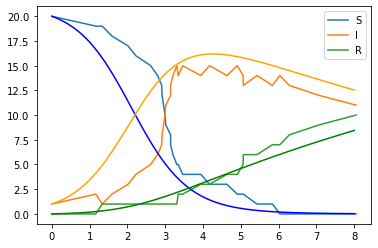

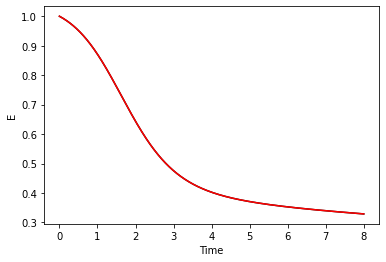

In [51]:
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

S_plot, = plt.plot(t,S, label="S")
I_plot, = plt.plot(t,I, label="I")
R_plot, = plt.plot(t,R, label="R")

plt.legend(handles=[S_plot, I_plot, R_plot])

# plot of the ODE simulation 


plt.plot(newt,y[:,0], color = 'blue') # S
plt.plot(newt,y[:,1], color = 'orange') # I
plt.plot(newt,y[:,2], color = 'green') # R


plt.show()

# interpolation of E(t) 
intpl = interp1d(newt, y[:,3], kind = 'cubic')
plt.plot(newt,y[:,3], color = 'black') #E
plt.plot(newt,intpl(newt), color = 'red') #E
plt.xlabel("Time")
plt.ylabel("E")
plt.show()

Calculation of likelihood (or loglikelihood) depends on calculation of Phi. Phi is given by phi_integrand() function (because it is the integrand in the integral). phi_integrand() calls ode_calc() and calc_lamda():

In [52]:
# a function to take time from shared ancestry matrix and pass it to ode_sim()
def ode_calc(ti,betap,gammap,psip):
    global S0, I0, R0, E0
    y0 = [S0,I0,R0,E0]
    params = [betap,gammap,psip] 
    time_of_simulation = np.linspace(0,ti,num=3)
    y = odeint(ode_sim,y0, time_of_simulation, args=(params,))
    return y

# calculation of lambda    
def calc_lamda(ti,betap,gammap,psip):
    y = ode_calc(ti,betap, gammap, psip)
    # lamda is beta*S(ti). S(ti) is the last time point of column 0 (S)
    lamda = betap*y[-1,0]
    return lamda

# this function takes ti: time from matrix
def phi_integrand(ti,betap,gammap,psip):
    global S0,E0
    mu = gammap
    if ti == 0:
        lamda = betap*S0
        return(float(-(betap*S0 + mu + psip)+2*lamda*E0))
    else:
        y = ode_calc(ti,betap, gammap, psip)
        lamda = betap*y[-1,0]
        phi_value = -(lamda + mu + psip) + 2*lamda*y[-1,3]
        return float(phi_value)

likelihood and loglikelihood functions, these functions take x (parameters) and data (here our shared ancestry matrix):

In [53]:
from scipy.integrate import quad
import math

# a function to calculate the likelihood
def likelihood(x,data):
    global psi # I don't want to explose likelihood based on psi at this moment, so I pass it as a variable
    betap = x[0]
    gammap = x[1]
    psip = psi
    tend2 = np.max(data)
    prd = math.exp(quad(phi_integrand, 0, tend2,args=(betap,gammap,psip))[0])
    
    # iterating over off diagonal elements, branching events
    for i in np.unique(data[:,-1][:-1]):
        # st makes the time backward
        st = tend2 - i
        res, err = quad(phi_integrand, 0, st, args=(betap,gammap,psip))
        prd = prd*math.exp(res)*calc_lamda(st,betap,gammap,psip)

    # iteratign over diagonal elements, sampling   
    for j in np.diagonal(data):
        st = tend2 - j
        res, err = quad(phi_integrand, 0, st,args = (betap,gammap,psip))
        prd = (prd*psip)/math.exp(res)
        
    return prd

# a function to calculate the loglikelihood
def loglikelihood(x,data):
    global psi # I don't want to explore loglikelihood based on psi at this moment, so I pass it as a variable
    betap = x[0]
    gammap = x[1] 
    psip = psi
    tend2 = np.max(data)
    get = quad(phi_integrand, 0, tend2,args=(betap,gammap,psip))[0]
    
    # iterating over off diagonal elements, branching
    for i in np.unique(data[:,-1][:-1]):
        # st makes the time backward
        st = tend2 - i
        res, err = quad(phi_integrand, 0, st,args = (betap,gammap,psip))
        get = get + res + np.log(calc_lamda(st, betap, gammap, psip))
               
    # iteratign over diagonal elements, sampling
    for j in np.diagonal(data):
        st = tend2 - j
        res, err = quad(phi_integrand, 0, st, args=(betap,gammap,psip))
        get = get + np.log(psip) - res
                
    return get

Calculating likelihood and loglikelihood:

In [54]:
# x is the list of parameters to be passed as argument to likelihood (or loglikelihood)
x = [beta,gamma]

LL = likelihood(x, dist_array)
print("log of the likelihood is:",np.log(LL))

LLL = loglikelihood(x,dist_array)
print("loglikelihood is:",LLL)

log of the likelihood is: -44.665997655321725
loglikelihood is: -44.665997655321725


Exploring loglikelihood surface with varying values of beta and gamma, this part takes time, be patient!

In [55]:
# gendat is a list to keep the generated loglikelihood values
gendat = [[],[],[]]
for i in np.arange(0.01,0.2,0.01):
    for j in np.arange(0.01,0.2,0.01):
        gendat[0].append(i)
        gendat[1].append(j)
        gendat[2].append(loglikelihood([i,j],dist_array))

Converting the list of lists to a matrix, then a dataframe and, fianally plotting:

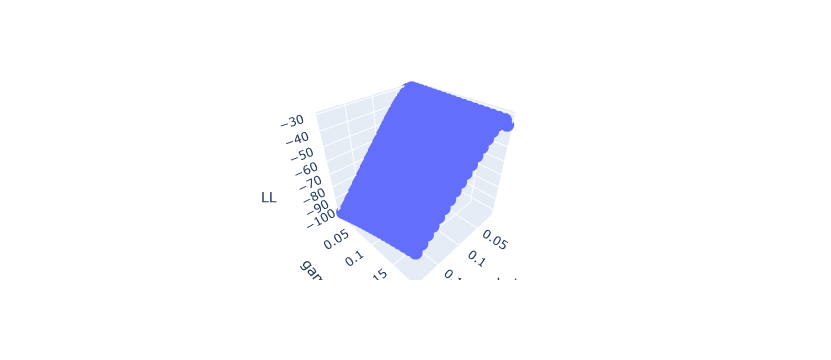

In [57]:
gendata = np.array(gendat)
# creating a dataframe
import pandas as pd
dict = {'beta': gendata[0,:], 'gamma': gendata[1,:], 'LL': gendata[2,:]} 
gendf = pd.DataFrame(dict)

# plotting
import plotly.express as px
# Plotting the figure
fig = px.scatter_3d(gendf, x = 'beta',
                    y = 'gamma',
                    z = 'LL',)
 
fig.show()